In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Task 1

In [4]:
img = cv2.imread("Images/fence.jpg")
img_arr = np.asarray(img)
print(img.shape)

(1250, 1000, 3)


## Task 1.1

In [26]:
def canny_edge_detector(image, kernel_blur, low_threshold, high_threshold , sigma):
#     # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian Blur
    im_filtered = cv2.GaussianBlur(gray_image, (kernel_blur, kernel_blur), sigma)
    
    # Define Sobel kernels for horizontal and vertical derivatives
    gx = cv2.Sobel(im_filtered, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(im_filtered, cv2.CV_64F, 0, 1, ksize=3)
    
    # Find the magnitude and angle of the gradients
    magnitude = np.sqrt(gx * gx + gy * gy)
    angle = np.arctan2(gy, gx) * 180 / np.pi
    # Update the negative values by making the range only within positives
#     angle[angle < 0] += 180
    
    angle_2 = np.arctan(gy, gx) * 180 / np.pi
#     angle_2[angle_2 < 0] += 180
    
    cv2.imwrite(f'./Report-Images/Task 1/Gradient-Images/angle_new_1.png' , angle)
    cv2.imwrite(f'./Report-Images/Task 1/Gradient-Images/angle_new_2.png' , angle_2)
    
    # Initialize the non-max suppression image
    image_height, image_width = gray_image.shape
    non_max_image = np.zeros((image_height, image_width), dtype=np.float32)
    
    # Assign the value of 140 to the weak pixels. This is chosen randomly
    # Assign the value of 255 for the strong pixels
    weak_pixel = np.uint8(140)
    strong_pixel = np.uint8(255)

    # Perform non-maximum suppression
    rows, cols = magnitude.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            current_angle = int(angle[i, j])

            # Define the neighbor pixels in 8-neighborhood and compare the angles
            # If the angles are either positive or negative which will not be 
            # in this scenario as we are already converting the negative values
            # to positives so look for the corresponding neighborhood as explained
            # in the report 8-neighborhood image. Hence this generally covers the
            # intuition of how can we make the comparison for different angles
            if (0 <= current_angle < 22.5) or (157.5 <= current_angle <= 180):
                neighbors = [magnitude[i, j-1], magnitude[i, j+1]]
            elif (22.5 <= current_angle < 67.5) or (-157.5 <= angle[i,j] < -112.5):
                neighbors = [magnitude[i-1, j+1], magnitude[i+1, j-1]]
            elif (67.5 <= current_angle < 112.5) or (-112.5 <= angle[i,j] < -67.5):
                neighbors = [magnitude[i-1, j], magnitude[i+1, j]]
            else:
                neighbors = [magnitude[i-1, j-1], magnitude[i+1, j+1]]

            # If neighbors are not stronger than the current, then let it as it is
            if magnitude[i, j] >= max(neighbors) and magnitude[i, j] >= high_threshold:
                non_max_image[i, j] = magnitude[i, j]
                
            # Or else suppress the lower thresholds and assign weak pixel
            # to the central limits. This weak pixel decision will then
            # be made using the next thresholding approach whether to keep
            # it or remove it.
            elif magnitude[i, j] >= low_threshold:
                non_max_image[i, j] = weak_pixel  # Mark as a weak edge

#     cv2.imwrite(f'./Report-Images/Task 1/Gradient-Images/non_max_image.png' , non_max_image)
    
    # Final resultant image
    result_image = np.zeros((image_height, image_width), dtype=np.uint8)

    # Apply hysteresis thresholding and edge connection
    for i in range(1, image_height-1):
        for j in range(1, image_width-1):
            if non_max_image[i, j] >= high_threshold:
                result_image[i, j] = strong_pixel
            elif non_max_image[i, j] >= low_threshold:
                result_image[i, j] = weak_pixel

    # Connect weak pixels to strong pixels
    for i in range(1, image_height-1):
        for j in range(1, image_width-1):
            if result_image[i, j] == weak_pixel:
                neighbors = result_image[i-1:i+2, j-1:j+2]
                if np.max(neighbors) == strong_pixel:
                    result_image[i, j] = strong_pixel
                else:
                    result_image[i, j] = 0

    return result_image


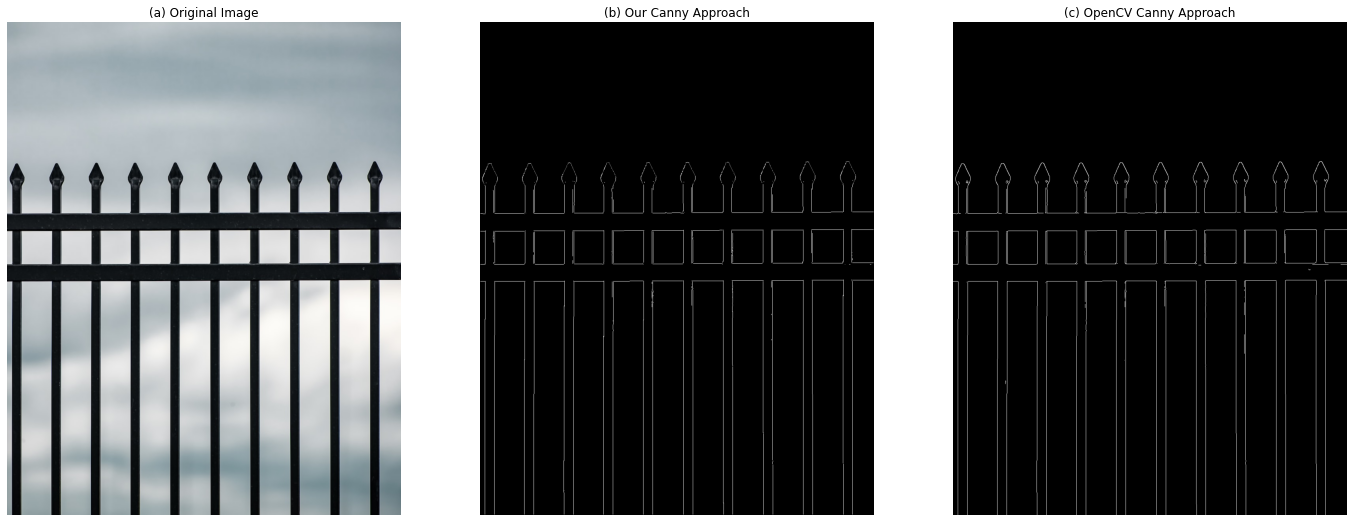

In [28]:
img = cv2.imread("Images/fence.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

if img is None:  # Check if image is loaded successfully
    print("Error: Unable to load image!")
else:
    low_threshold_value = 150
    high_threshold_value = 200
    kernel_blur = 7
    sigma = 1
    
    result_manual = canny_edge_detector(img, kernel_blur, low_threshold_value, high_threshold_value , sigma)

    # Comparing with OpenCV's Canny function
#     results_opencv = cannyOpenCV(img_gray, kernel_blur, low_threshold_value, high_threshold_value)
    
    imgBlur = cv2.GaussianBlur(img_gray, (kernel_blur, kernel_blur), sigma)
    # canny edge detection
    results_opencv = cv2.Canny(imgBlur, low_threshold_value, high_threshold_value)

#     cv2.imwrite(f'./Report-Images/Task 1/Filter-Effect/Our-Canny-Output-{sigma}.png' , result_manual)
#     cv2.imwrite(f'./Report-Images/Task 1/Filter-Effect/OpenCV-Canny-Output-{sigma}.png' , results_opencv)
    
    fig, ax = plt.subplots(1,3, figsize=(24,12))

    # Plot histogram of each channel on one above the other 
    ax[0].imshow(img , cmap = 'gray')
    ax[1].imshow(result_manual , cmap = 'gray')
    ax[2].imshow(results_opencv , cmap = 'gray')
    
    ax[0].set_title('(a) Original Image')
    ax[1].set_title('(b) Our Canny Approach')
    ax[2].set_title('(c) OpenCV Canny Approach')
    
#     plt.grid(False)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    

## Task 1.2: Counting Posts using the Zero-Crossing

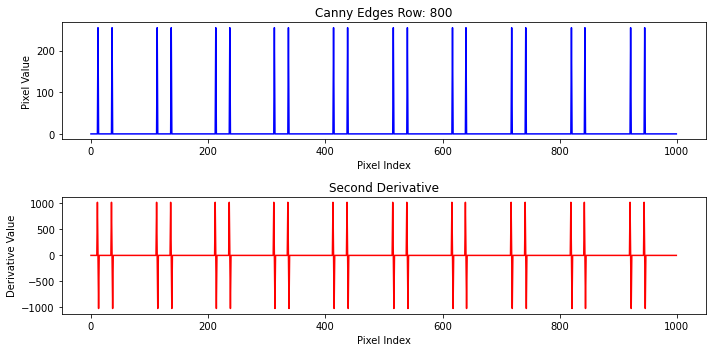

In [14]:
row_secondDerivative = 800

gx = cv2.Sobel(result_manual, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(result_manual, cv2.CV_64F, 0, 1, ksize=3)
magnitude = np.sqrt(gx * gx + gy * gy)
angle = np.arctan2(gy, gx) * 180 / np.pi

# Plot first derivate and second derivate to see the zero-crossing in it
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(result_manual[row_secondDerivative,:], color='b', label='Original Row')
plt.title(f'Canny Edges Row: {row_secondDerivative}')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Value')

plt.subplot(2, 1, 2)
plt.plot(gx[row_secondDerivative,:], color='r', label='Second Derivative')
plt.title('Second Derivative')
plt.xlabel('Pixel Index')
plt.ylabel('Derivative Value')

plt.tight_layout()
plt.show()

# print("The second derivative output: ")
# print(gx[row_secondDerivative,:])

In [15]:
# Note: This implementation is an additional step to cross-check the working
# of zero-crossing for edge detection. The main implementation is the
# one used using morphological operations.
def countZeroCrossing(row):
    width = len(gx[row_secondDerivative,:])
    num_zero_crossings = 0
    # Here we are looking for the following response,
    # Like, 0 , 0, 0, 100 , 0 , 100 , 0 , 0 ,0
    # So we count all such responses
    for i in range(1, width - 1):
        left = row[i-1]
        right = row[i+1]
        
        if row[i] == 0 and left > row[i] and right < row[i]:
            num_zero_crossings += 1
#             print(i)
            
    # We are dividing by 2 because each post has two edge boundaries
    # So it means that two zero crossings will represent a signle post.
    # So total, we have 20 zero-crossings so we get 10 posts in total.
    num_posts = int(num_zero_crossings / 2)
    
    return num_posts

num_posts = countZeroCrossing(gx[row_secondDerivative,:])
print("Total number of Posts using Zero-Crossing Approach: " , num_posts)

Total number of Posts using Zero-Crossing Approach:  10


## Task 1.2: Posts Counting Using Morphological Operations

In [18]:
def countPosts(img , result_manual):
    # Extract the top portion of the posts which has the main hooks area
    # This will help in counting by using the contours approach
    plots_region = result_manual[ 300:450 , :].copy()
    img_region = img[ 300:450 , :].copy()
    kernel = np.ones((3, 3), np.uint8)

    # Apply Dilation to make the edges more stronger and thicker
    # This help mitigate the non-connected edges
    # Then, apply the closing which will fill-in the gap area of the top
    # hooks. This is done so that we get the solid regions for our contour
    # rather than having irregular contours
    dilated = cv2.dilate(plots_region, kernel, iterations=4)
    closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=19)

    # Find the contours
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_NONE)

    num_posts = 0
    
    # This is one approach by finding the area of the contour. So our post contour will be greater than 100
    # As we applied the morphological operations such that the dis-continuity is removed.
    # That is why we are not having random contours. Instead we have a complete rounded contour of area > minArea.
    min_area = 10
    for contour in contours:
        # Specify some limit for each post contour area. Althoug, we are
        # using the contours directly for counting but in case if we had 
        # different contours then the area-based approach is the most
        # convenient to use
        area = cv2.contourArea(contour)
        if area > min_area:
    #         print(area)
            num_posts += 1

    # Or the other way around is the number of contours in this case i.e., 10 because we will not have any other contours
    cv2.drawContours(img_region, contours, -1, (0,255,0), 3)

    print("Total Number of Posts from Contours: " , len(contours))
    print("Total number of Posts using Area Approach: " , num_posts)


    fig, ax = plt.subplots(2,2, figsize=(24,12))

    # Plot histogram of each channel on one above the other 
    ax[0][0].imshow(plots_region , cmap = 'gray' )
    ax[0][1].imshow(dilated , cmap = 'gray')
    ax[1][0].imshow(closing , cmap = 'gray')
    ax[1][1].imshow(img_region)
    
    ax[0][0].set_title('Canny Edges')
    ax[0][1].set_title('Processed using Dilation')
    ax[1][0].set_title('Processed using Closing')
    ax[1][1].set_title('Contours on Original Image')
    
    return num_posts

Total Number of Posts from Contours:  10
Total number of Posts using Area Approach:  10


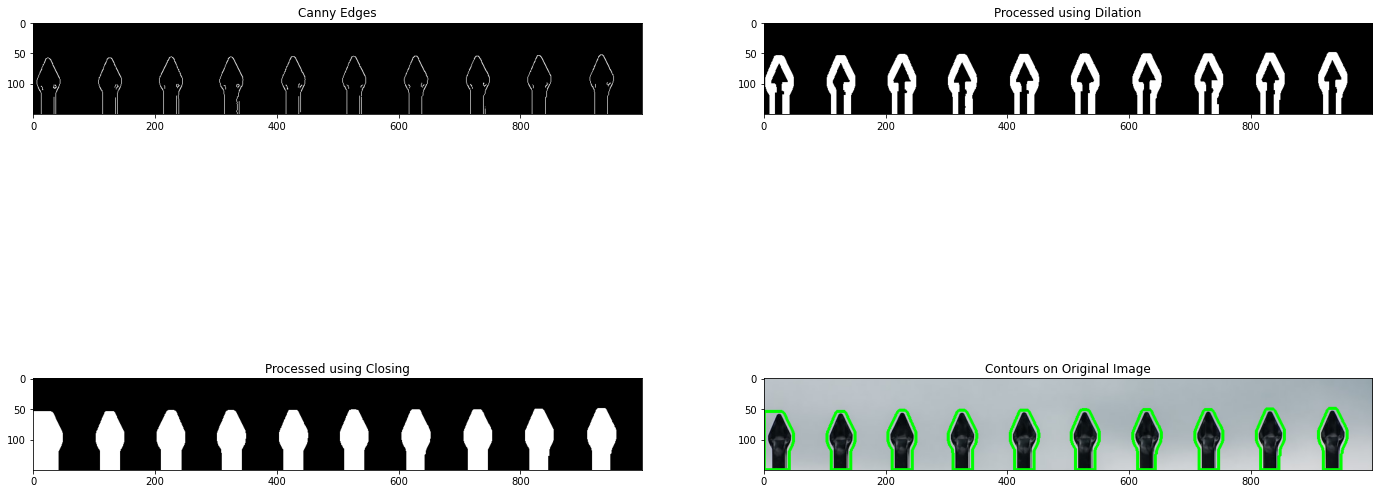

In [19]:
number_posts = countPosts(img , results_opencv)

In [ ]:
#     cv2.imwrite('./Report-Images/Task 1/Task 1.2/canny-edges-posts.png' , plots_region)
#     cv2.imwrite('./Report-Images/Task 1/Task 1.2/dilation.png' , dilated)
#     cv2.imwrite('./Report-Images/Task 1/Task 1.2/closing.png' , closing)
#     cv2.imwrite('./Report-Images/Task 1/Task 1.2/contouors-original-plots-region.png' , img_region)
